# 3D-Films: Projecting Insights from the Screen to Your Office

By: Danayt Aman, Deniz Emre, and David Hartsman

______________________________________________________________________________________________________________________

## Overview

3D-Films conducted an in-depth review of movie data in order to provide informed advice to a prospective new entrant into the film industry. We parsed through box office numbers, film ratings, personnel, and genre representation to determine an optimized approach to building a cinematic empire. After conducting our analysis, we have determined that the strongest correlation for production budget to profit occurs in the highest tier of budget allocation, specifically above 100 million dollar budgets. That being said, all budget tiers were profitable. Secondly, we also determined that the Horror genre is an ideal genre for producing cost-effective films with a great track ROI track record. Our third insight is that using buzz-worthy personnel is useful for cultivating buzz and excitement amongst the public.

## Business Problem

A company approached 3D-Films asking for business insights and advice about the film industry. Our clients hope to compete with current industry leaders and other large companies who have recently entered the media business. We were tasked with finding three actionable insights to help make their entry to the business as impactful as possible.

We hoped to address some key considerations:
-  What determines the "success" of a movie?
-  Are there certain genres that are represented more frequently amongst the highest earners?
-  Are there key personnel figures who have an outsized impact on a film's success?

## Data Understanding

We parsed through several different sources of data. Our data was taken from a number of sites that track the movie industry. The data contained a tremendous amount of information including information regarding box office revenue, production budgets, release dates, and reviews from critics and regular people as well. We put profit first in our analysis, and then provided options to pursue depending on the clients' preferred budget, genre, or critical appeal.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sqlite3
from zipfile import ZipFile # for unzipping the db.zip file
pd.set_option('display.max_columns', None) # show all columns when printing out dataframe
plt.style.use("fivethirtyeight")
import scipy.stats as stats

from mpl_toolkits import mplot3d
import sklearn.metrics as metrics
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

## Data Preparation

We began our data preparation by taking a look at the financial data available to us. We wanted to assess the most profitable movies in both nominal terms, and in terms of return on investment. We broke our data down into four ranges of budgets, and modeled the relationship between budget and profit. 

We also had relational tables from imdb that required cleaning and consolidation. 

## Data Modeling

In [2]:
# import the budget data
tn_df = pd.read_csv("zippedData/cleaned_budget_data.csv")
final_data = pd.read_csv("zippedData/final_data.csv")

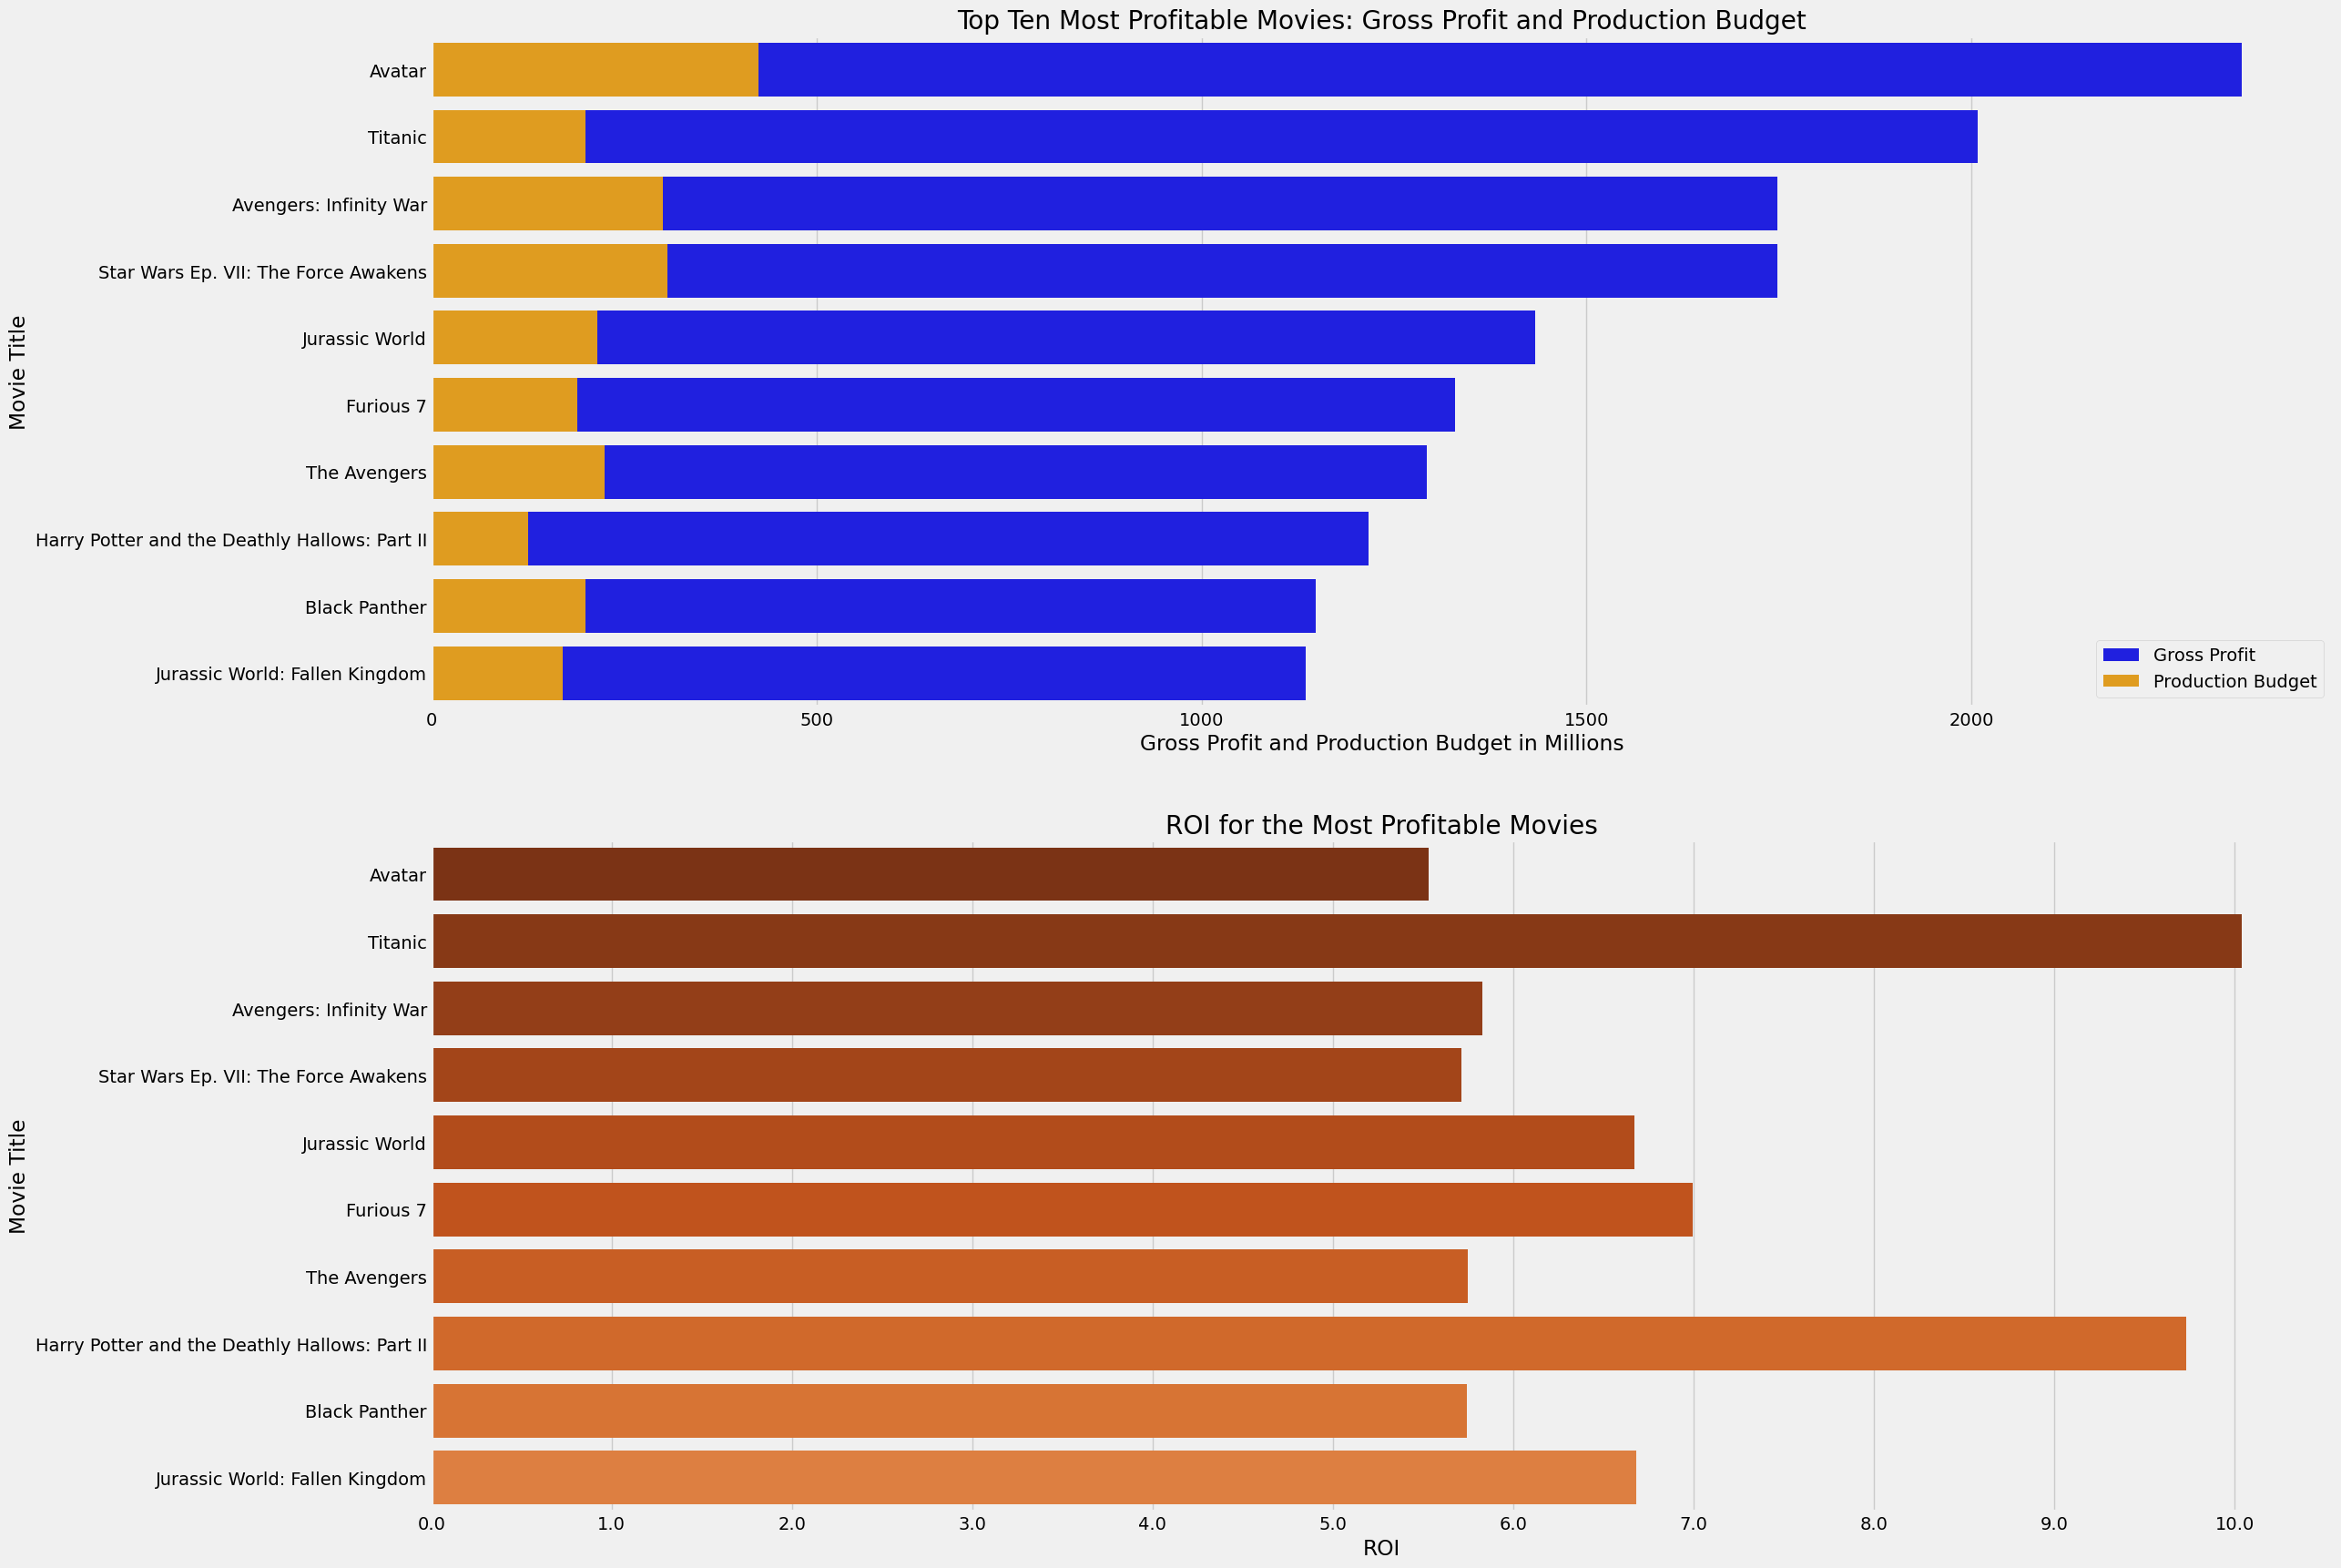

In [3]:
# Plotting Profit vs Budget for the Movies with the largest gross profit
fig, ax = plt.subplots(nrows=2, figsize=(24,20))

# Creates new df object to assist with plotting 
top_movies = tn_df.sort_values(by='gross_profit', ascending=False)[:10]

# Creates stacked bar plot showing total profit in blue, budget in yellow
sns.barplot(x='gross_profit', y='movie', data=top_movies, color='blue', ax=ax[0], label='Gross Profit')
sns.barplot(x='production_budget', y='movie', data=top_movies, color='orange', ax=ax[0], label='Production Budget')

# Labels and Titles
ax[0].set_xlabel("Gross Profit and Production Budget in Millions")
ax[0].set_ylabel("Movie Title")
ax[0].set_title("Top Ten Most Profitable Movies: Gross Profit and Production Budget")
ax[0].legend()
plt.xticks(np.arange(0, 2420, 100))

greens = sns.color_palette("Oranges_r", 22)
sns.barplot(x='roi', y='movie', data=top_movies, ax=ax[1], palette=greens)
ax[1].set_xlabel("ROI")
ax[1].set_ylabel("Movie Title")
ax[1].set_xticks(np.arange(0, top_movies['roi'].max(), 1))
ax[1].set_xticklabels(np.arange(0, top_movies['roi'].max(), 1))
ax[1].set_title("ROI for the Most Profitable Movies");

We then contrasted the best grossing films with the biggest money losers.

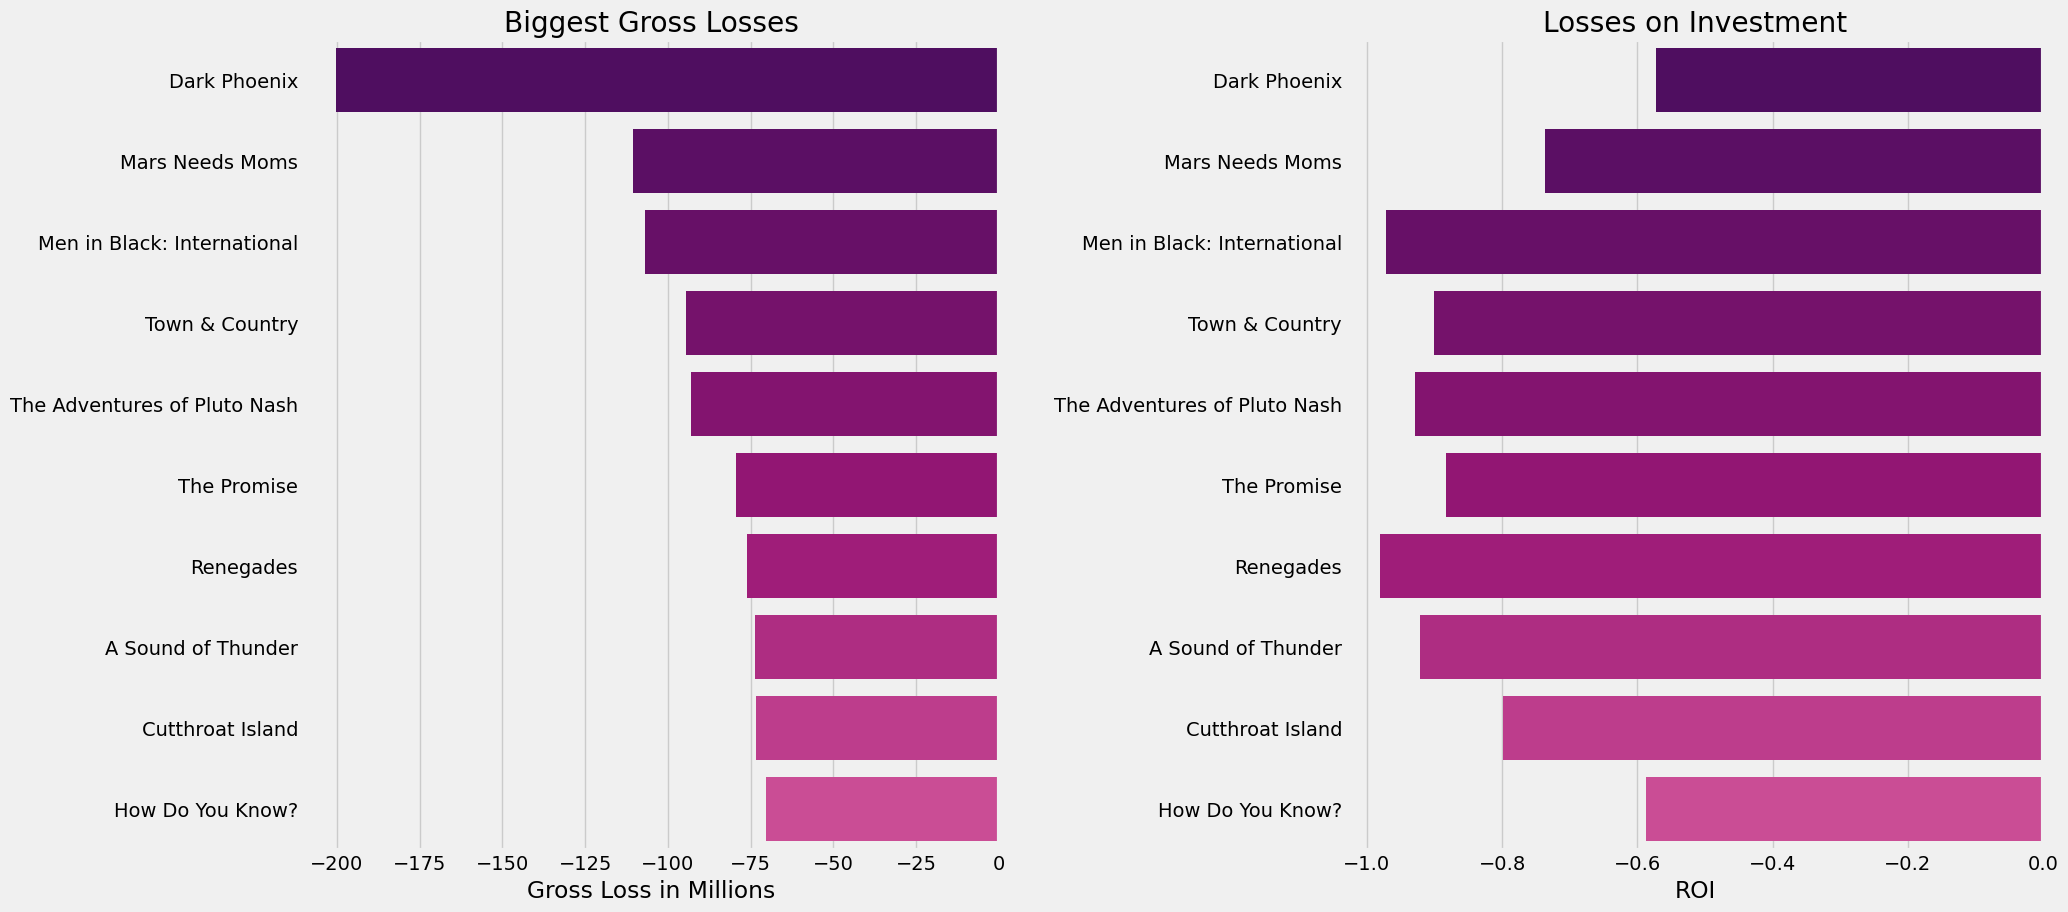

In [4]:
# plotting worst financial movies
ten_worst = tn_df.sort_values(by="gross_profit", ascending=True)[:10]

# setting color, figsize
greens = sns.color_palette("RdPu_r", 25)
fig, ax = plt.subplots(ncols=2, figsize=(20,10), gridspec_kw={'wspace': .5})

# plot gross profit
sns.barplot(y='movie', x='gross_profit', data=ten_worst, ax=ax[0], palette=greens)
ax[0].set_xlabel("Gross Loss in Millions")
ax[0].set_ylabel("")
ax[0].set_title("Biggest Gross Losses")
ax[1].set_yticklabels("")

# plot loss on investment
sns.barplot(y='movie', x='roi', data=ten_worst.sort_values(by='gross_profit', ascending=True), ax=ax[1], palette=greens)
ax[1].set_ylabel("")
ax[1].set_xlabel("ROI")
ax[1].set_title("Losses on Investment");

After observing some key similarities between the groups, we separated our data by budget ranges.

In [5]:
# creates top 25% group, 25-75 group, bottom 25% group by budget
most_exp = tn_df.loc[tn_df['quartile'] == "Top 25"]
inner_quartile = tn_df.loc[(tn_df['quartile'] == "50-75") | (tn_df['quartile'] == "25-50")]
bottom_quartile = tn_df.loc[tn_df['quartile'] == "Bottom 25"]

# breaks top quartile (most_exp) into 2 groups on either side of 100M, and prints loss rates

hundred_plus = most_exp.loc[most_exp['production_budget'] > 100.0000]
forty_to_hundred = most_exp.loc[most_exp['production_budget'] <= 100.0000]

We looked at some key descriptive statistics from each budget range.

In [6]:
# display mean and median profits
print(f"""Mean/Median Profits (Millions): 
100M+   | Mean:{round(np.mean(hundred_plus['gross_profit']), 2)}  | Median: {round(np.median(hundred_plus['gross_profit']), 2)}
42M-100M| Mean:{round(np.mean(forty_to_hundred['gross_profit']), 2)}  | Median: {round(np.median(forty_to_hundred['gross_profit']), 2)}
6M-42M  | Mean:{round(np.mean(inner_quartile['gross_profit']), 2)}   | Median: {round(np.median(inner_quartile['gross_profit']), 2)}
<6M     | Mean:{round(np.mean(bottom_quartile['gross_profit']), 2)}   | Median: {round(np.median(bottom_quartile['gross_profit']), 2)}
""")

# display mean and median ROI's
print(f"""Mean/Median ROI's: 
100M+    | Mean:{round(np.mean(hundred_plus['roi']), 2)}    | Median: {round(np.median(hundred_plus['roi']), 2)}
42M-100M | Mean:{round(np.mean(forty_to_hundred['roi']), 2)}   | Median: {round(np.median(forty_to_hundred['roi']), 2)}
6M-42M   | Mean:{round(np.mean(inner_quartile['roi']), 2)}   | Median: {round(np.median(inner_quartile['roi']), 2)}
<6M      | Mean:{round(np.mean(bottom_quartile['roi']), 2)}   | Median: {round(np.median(bottom_quartile['roi']), 2)}
""")

# prints what percentage of movies lose value at each of the 4 budget tiers

perc_loss_Hplus = len(hundred_plus.loc[hundred_plus['gross_profit'] < 0]) / len(hundred_plus)
perc_loss_FtH = len(forty_to_hundred.loc[forty_to_hundred['gross_profit'] < 0]) / len(forty_to_hundred)
perc_loss_mid = len(inner_quartile.loc[inner_quartile['gross_profit'] < 0]) / len(inner_quartile)
perc_loss_bot = len(bottom_quartile.loc[bottom_quartile['gross_profit'] < 0]) / len(bottom_quartile)

print(f"""PROFITABILITY RATES: 
100M+    | {round(100 * (1-perc_loss_Hplus), 2)}%
42M-100M | {round(100 * (1-perc_loss_FtH), 2)}%
6M-42M   | {round(100 * (1-perc_loss_mid), 2)}%
<6M      | {round(100 * (1-perc_loss_bot), 2)}%""")

print("Maximum loss:", hundred_plus['gross_profit'].min(), hundred_plus.loc[
    hundred_plus['gross_profit'].idxmin()]['movie'])

Mean/Median Profits (Millions): 
100M+   | Mean:357.32  | Median: 268.9
42M-100M| Mean:102.68  | Median: 63.67
6M-42M  | Mean:37.87   | Median: 12.85
<6M     | Mean:12.53   | Median: 1.21

Mean/Median ROI's: 
100M+    | Mean:2.2    | Median: 1.83
42M-100M | Mean:1.54   | Median: 0.95
6M-42M   | Mean:2.06   | Median: 0.72
<6M      | Mean:10.6   | Median: 0.9

PROFITABILITY RATES: 
100M+    | 93.37%
42M-100M | 74.38%
6M-42M   | 64.66%
<6M      | 61.79%
Maximum loss: -200.238 Dark Phoenix


We then modeled regression lines for the data in each budget range. We believe that our model provides some predictive guidance for expected financial return based on how much money our client chooses to invest. 

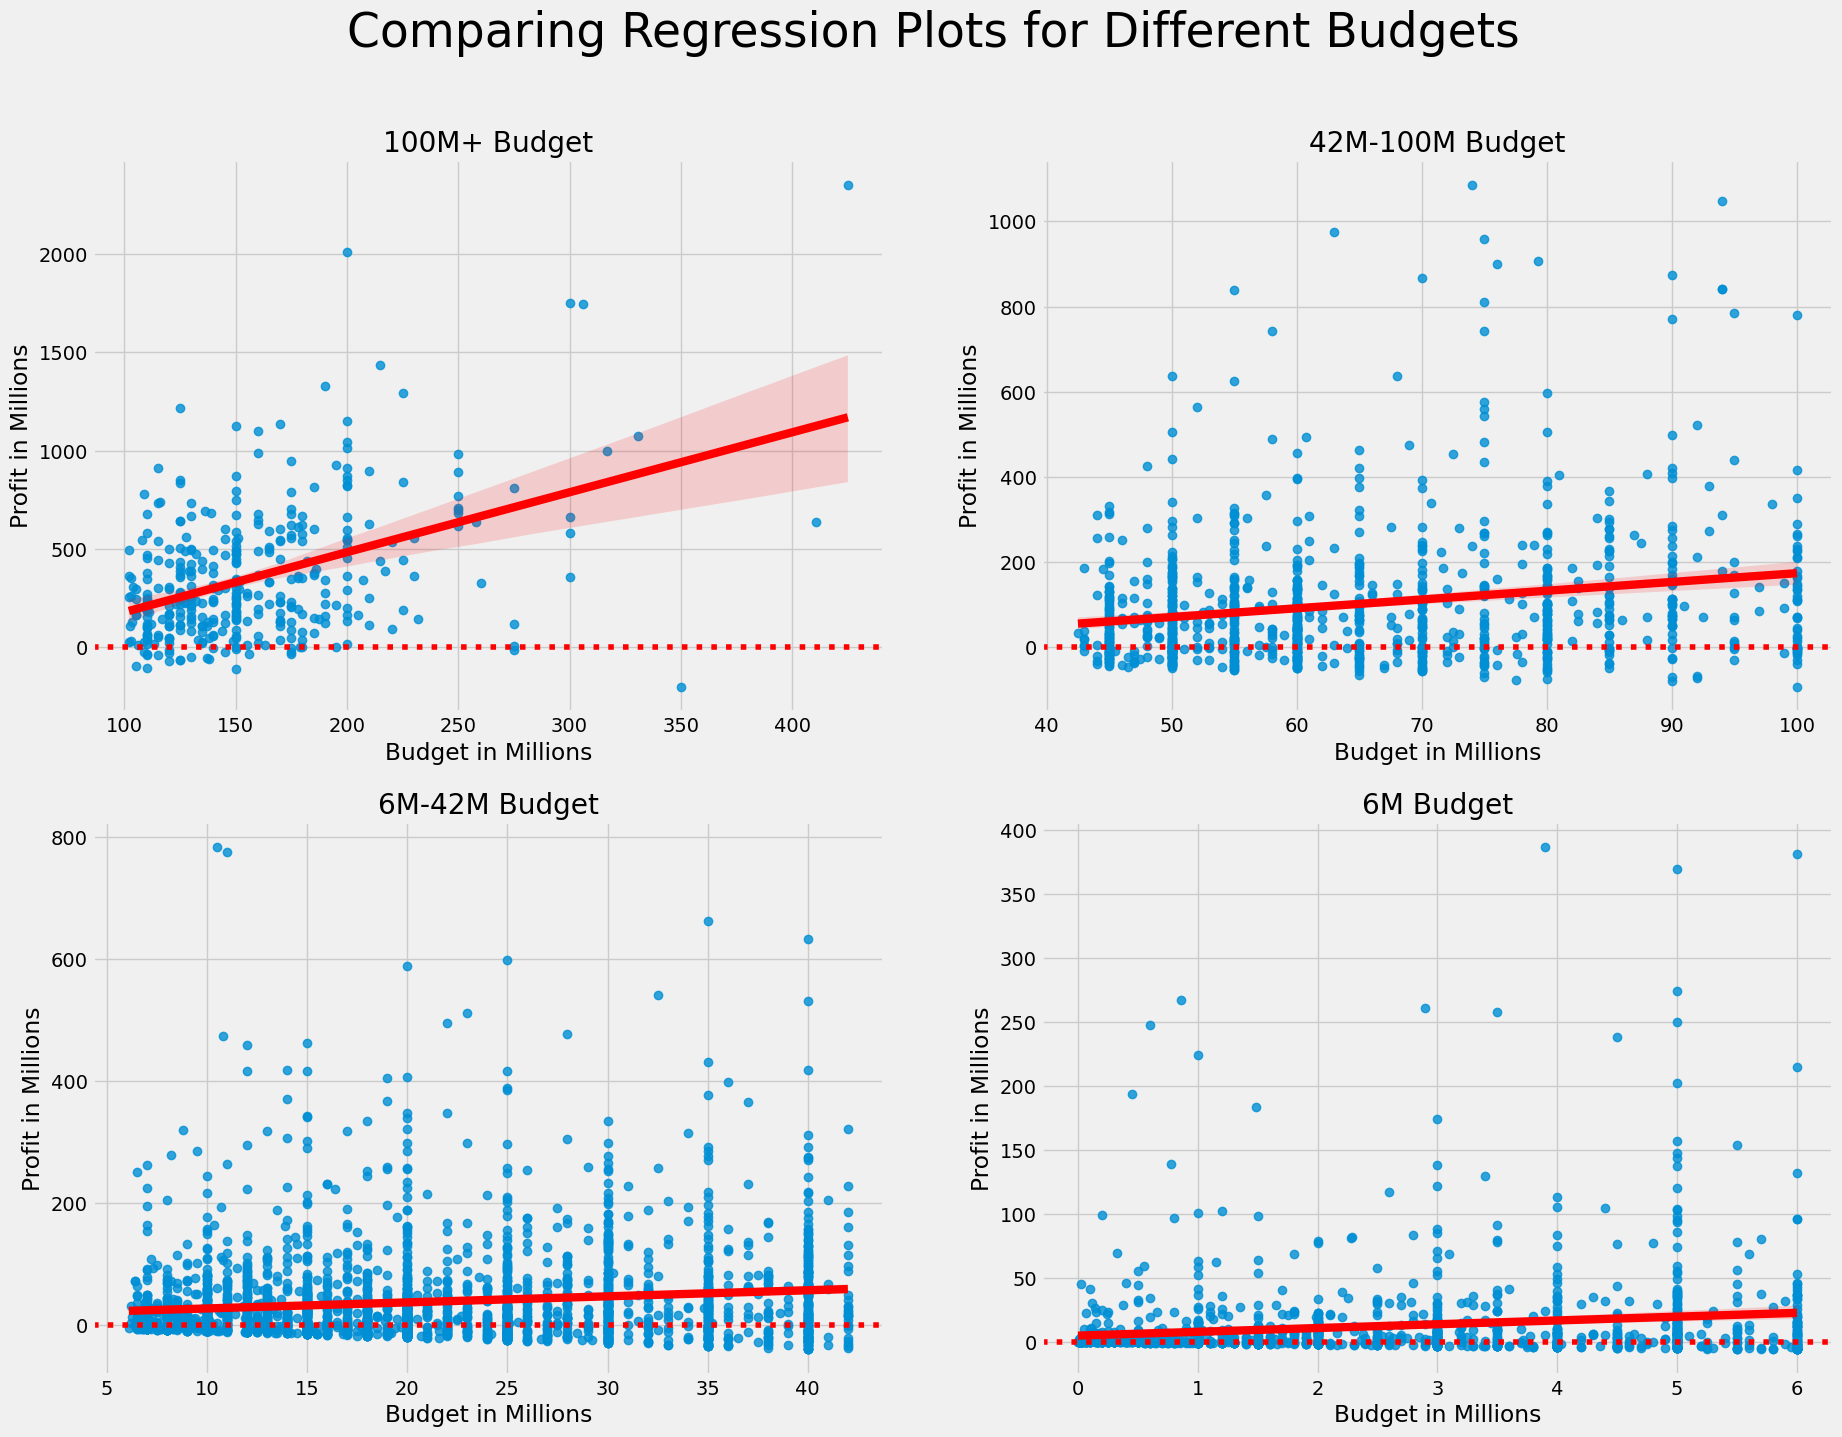

In [7]:
# creating a plot to show the regression charts of all 4 budget groups 
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))

sns.regplot(x="production_budget", y= "gross_profit", data=hundred_plus, line_kws={"color": "red"}, ax=ax[0][0])
ax[0][0].axhline(y=0, color='red', linestyle='dotted')
ax[0][0].set_ylabel("Profit in Millions")
ax[0][0].set_xlabel("Budget in Millions")
ax[0][0].set_title("100M+ Budget")

sns.regplot(x="production_budget", y= "gross_profit", data=forty_to_hundred, line_kws={"color": "red"}, ax=ax[0][1])
ax[0][1].axhline(y=0, color='red', linestyle='dotted')
ax[0][1].set_ylabel("Profit in Millions")
ax[0][1].set_xlabel("Budget in Millions")
ax[0][1].set_title("42M-100M Budget")

sns.regplot(x="production_budget", y= "gross_profit", data=inner_quartile, line_kws={"color": "red"}, ax=ax[1][0])
ax[1][0].axhline(y=0, color='red', linestyle='dotted')
ax[1][0].set_ylabel("Profit in Millions")
ax[1][0].set_xlabel("Budget in Millions")
ax[1][0].set_title("6M-42M Budget")

sns.regplot(x="production_budget", y= "gross_profit", data=bottom_quartile, line_kws={"color": "red"}, ax=ax[1][1])
ax[1][1].axhline(y=0, color='red', linestyle='dotted')
ax[1][1].set_ylabel("Profit in Millions")
ax[1][1].set_xlabel("Budget in Millions")
ax[1][1].set_title("6M Budget")

plt.suptitle("Comparing Regression Plots for Different Budgets", fontsize=34);

Our predictive models are:

100M+        
y = 3.046*x + -125.59

42M-100M     
y = 2.06*x + -32.18

6M-42M       
y = .99*x + 17.35

6M or Less   
y = 2.96*x + 4.86

As you can see from the charts, the correlation between expenditures and profits is strongest for the highest budget levels, and it diminishes every tier that you move down. As the correlation gets smaller, our predictive models become less reliable. We therefore concluded that below $42 million budgets, there are qualitative factors that impact the success of movies more than the amount of money spent. 

# Analysis
>- Genre vs return analysis

# Profit and Ratings
>- We looked at the correlation between review-rates a profitability
>>- We found a moderate correlation at 31%
>>- Movies with higher review-rates moderately had higher profit
>- Based on these analysis we dived into creatives associated with postive reviews
>>- We focused on:
>>>- Actors,Actress, Directors and Writers

In [11]:
# Convert 'genres' to string and then split
final_data['genres'] = final_data['genres'].astype(str).str.split(',')
# Explode the 'genres' column
final_data_exp = final_data.explode('genres')

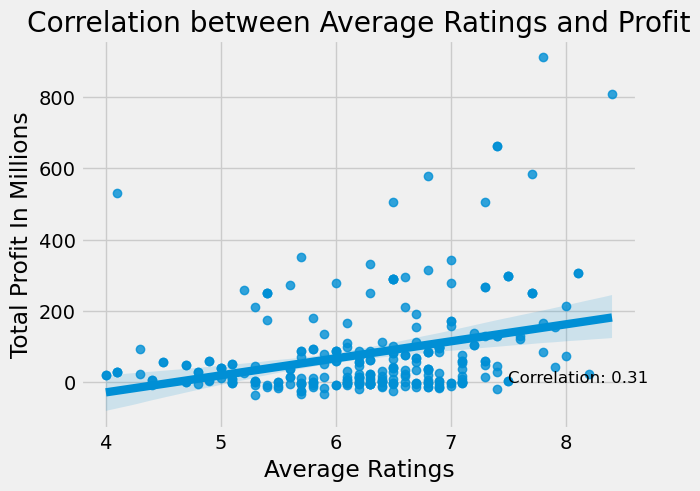

In [12]:
Actors_Actress = final_data_exp[(final_data_exp['category'].isin(['actor', 'actress','writer'])) & 
                        (final_data_exp['genres'].str.contains('Horror|Mystery|Thriller')) &
                               (final_data_exp['avg_ratings']) &
                               (final_data_exp['release_date'] >= '2011-01-01') &
                               (final_data_exp['num_votes'] >= 9000)]

# Sort the actors and actresses by average ratings in descending order
Actors_Actress = Actors_Actress.sort_values(by='avg_ratings', ascending=False)

# Calculate the correlation between average ratings and ROI
correlation = np.corrcoef(Actors_Actress['avg_ratings'], Actors_Actress['total_profit'])[0, 1]

sns.regplot(x=Actors_Actress['avg_ratings'], y=Actors_Actress['total_profit'])
plt.xlabel('Average Ratings')
plt.ylabel('Total Profit In Millions')
plt.title('Correlation between Average Ratings and Profit')

plt.text(7.5, 0.2, f'Correlation: {correlation:.2f}', fontsize=12)

plt.show()

# Best Directors for the Horror/Thriller/Mystry Genre
> - David Fincher
> - John Madden
> - Kathryn Bigelow
> - Derek Cianfrance
> - Oliver Stone

In [8]:
# Convert 'genres' to string and then split
final_data['genres'] = final_data['genres'].astype(str).str.split(',')
# Explode the 'genres' column
final_data_exp = final_data.explode('genres')
directors = final_data_exp[(final_data_exp['category'] == 'director') & 
                           (final_data_exp['genres'].str.contains('Horror|Thriller|Mystery')) &
                           (final_data_exp['avg_ratings'] >= 7) &
                           (final_data_exp['num_votes'] >= 9000)]

# Sort the directors by ratings in descending order
directors = directors.sort_values(by='avg_ratings', ascending=False)['artist_name'].unique()

# Print the director names with ratings
print("Best Directors:")
for name in directors:
    print(name)

Best Directors:
David Fincher
John Madden
Kathryn Bigelow
Derek Cianfrance
Oliver Stone


# Best Writers for the Horror/Thriller/Mystry Genre
> - Stephen King
> - Dario Argento
> - Phil Hay
> - John Carpenter
> - Colin Bateman
> - Scot Armstrong
> - Sam Raimi

In [9]:
Writers = final_data_exp[(final_data_exp['category'].isin(['writer'])) & 
                           (final_data_exp['genres'].str.contains('Horror|Thriller|Mystery'))&
                           (final_data_exp['avg_ratings'] >= 6.5)]

# Get the unique names from the 'artist_name' column
Writers = Writers.sort_values(by='avg_ratings', ascending=False)['artist_name'].unique()

# Print the director names
print("Best Writers:")
for name in Writers:
    print(name)

Best Writers:
Stephen King
Dario Argento
Phil Hay
John Carpenter
Colin Bateman
Scot Armstrong
Sam Raimi


# Best Actor/Actress for the Horror/Thriller/Mystry Genre
> - Leonardo DiCaprio
> - Natalie Portman
> - Ben Affleck
> - Tom Hanks
> - Gary Oldman
> - Javier Bardem
> - Matthew Goode
> - Lili Taylor
> - Forest Whitaker
> - Samuel L. Jackson
> - Sandra Bullock
> - Ewan McGregor
> - Harrison Ford
> - Sean Bridgers
> - Catherine Keener

In [10]:
Actors_Actress = final_data_exp[(final_data_exp['category'].isin(['actor','actress']))& 
                           (final_data_exp['genres'].str.contains('Horror|Thriller|Mystery'))&
                           (final_data_exp['avg_ratings'] >= 7.5) &
                           (final_data_exp['num_votes'] >= 9000)]

# Get the unique names from the 'artist_name' column
Actors_Actress = Actors_Actress['artist_name'].unique()


print("Actors and Actress:")
for name in Actors_Actress:
    print(name)

Actors and Actress:
Leonardo DiCaprio
Natalie Portman
Ben Affleck
John C. Reilly
Tom Hanks
Gary Oldman
Rene Russo
Javier Bardem
Lubna Azabal
Matthew Goode
Lili Taylor
Forest Whitaker
Samuel L. Jackson
Sandra Bullock
Ewan McGregor
Harrison Ford
Sean Bridgers
Catherine Keener


# Recommendations
>- 1. High Budget Yields High Returns. High Budget Has High Risks
>> -
>- 2. Horror|Thriller|Mystery Genres Low Budget High Returns
>> - Fall season And Specifically October As Optimal Release Month
>> -
>- 3. Personnel with High Reviews To Consider 
 > > - Actor: Leonardo DiCaprio
 > > - Actress: Natalie Portman
 > > - Drirector: David Fincher
 > > - Writer: Stephen King

# Conclusion

Based on our analysis, we have found that expenditure had strong correlation with profit, movies with high budget had highest turns in comparison to those with low budget. We also found that gloal premier yielded higher income compared to domestic or foreign returns. We de dived deeper into genres, low-budget horror and mystery movies tend to yield the highest return on investment (ROI). 

Considering the financial risks associated with high-budget films, we recommend that a new film studio focuses on producing low-budget horror and mystery movies. By starting with these genres, the studio can minimize financial risks while still capitalizing on the high ROI potential the genre offers. This approach allows the studio to gain experience and establish a foothold in the industry before venturing into more expensive projects.This conclusion is based on the data we have examined, which indicates that these genres have a strong potential for profitability.

It is important to note that our analysis is based on the available data and industry trends. The success of any movie project depends on various factors, including marketing strategies, storytelling, and audience reception. However, by focusing on low-budget horror and mystery movies and aligning their release with the Halloween season, a new film studio can increase their chances of achieving a higher ROI. Aiming for writers, directors, actors and actresses that are associated with movies with highest ratings is also a good strategy to maximize popularity and establish a strong presence in the industry. 